<a href="https://colab.research.google.com/github/AnupDesai/Deep-Fake-Detection-using-MesoNet/blob/main/DeepFake_Detection_using_MesoNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive',force_remount=True)

Mounted at /content/gdrive


**Load Torch as well as some python libraries**

In [ ]:
import torch
import numpy as np
from tqdm.auto import tqdm
import pandas as pd
import matplotlib.pyplot as plt
print(torch.__version__)
import torchvision
from torch import nn

# torch vision libraries
from torchvision import datasets
from torchvision import transforms
from torchvision.transforms import ToTensor
from torch.utils.data import DataLoader

device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)

1.13.1+cu116
cuda


In [ ]:
# Get some data
import zipfile
from pathlib import Path

# Setup a data folder
data_path= Path("data/")
image_path= data_path/"deepfake_image"


if image_path.is_dir():
  print(f"{image_path} skipping download")
else:
  print("downloading the file")
  image_path.mkdir(parents=True, exist_ok=True)

with zipfile.ZipFile("/content/gdrive/MyDrive/data.zip", "r") as zipRef:
  print("Unzipping the zip file")
  zipRef.extractall(image_path)


downloading the file
Unzipping the zip file


In [ ]:
# Setup train and testing paths
train_dir= image_path/"/content/data/deepfake_image/content/real_vs_fake/real_fake/train"
test_dir= image_path/"/content/data/deepfake_image/content/real_vs_fake/real_fake/test"

train_dir, test_dir

(PosixPath('/content/data/deepfake_image/content/real_vs_fake/real_fake/train'),
 PosixPath('/content/data/deepfake_image/content/real_vs_fake/real_fake/test'))

In [ ]:
import random
from PIL import Image
random.seed(42)
image_path_list= list(image_path.glob("*/*/*/*/*/*.jpg"))
random_image_path= random.choice(image_path_list)
image_class= random_image_path.parent.stem
img= Image.open(random_image_path)
print(f"Random image path: {random_image_path}")
print(f"Image class: {image_class}")
print(f"Image height: {img.height}")
print(f"Image width: {img.width}")

Random image path: data/deepfake_image/content/real_vs_fake/real_fake/valid/real/10218.jpg
Image class: real
Image height: 256
Image width: 256


(-0.5, 255.5, 255.5, -0.5)

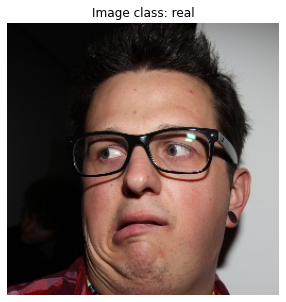

In [ ]:
# use matplotlib to visualize the data
import numpy as np
import matplotlib.pyplot as plt

img_as_array= np.asarray(img)
plt.figure(figsize=(10,5))
plt.imshow(img_as_array)
plt.title(f"Image class: {image_class}")
plt.axis(False)

In [ ]:
from torchvision import transforms

data_transfrom= transforms.Compose([
    transforms.Resize(size=(64,64)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor()
])


**Visualizing a part of the dataset**

[PosixPath('data/deepfake_image/content/real_vs_fake/real_fake/valid/real/10218.jpg'), PosixPath('data/deepfake_image/content/real_vs_fake/real_fake/test/real/31117.jpg'), PosixPath('data/deepfake_image/content/real_vs_fake/real_fake/train/real/44451.jpg')]


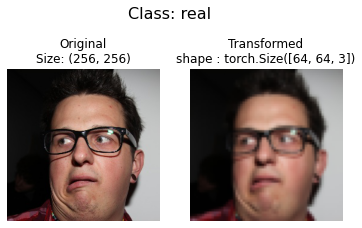

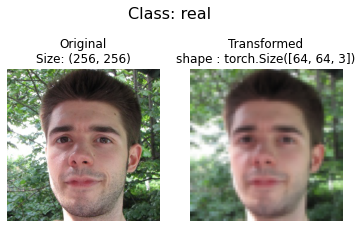

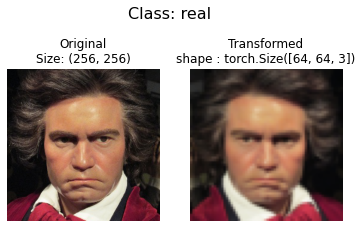

In [ ]:
def transform_image(image_paths, transform, n=3, seed=None):
  random.seed(seed)
  random_image_paths= random.sample(image_paths, k=n)
  print(random_image_paths)
  for image_path in random_image_paths:
    with Image.open(image_path) as f:
      fig,ax= plt.subplots(1,2)
      ax[0].imshow(f)
      ax[0].set_title(f"Original\nSize: {f.size}")
      ax[0].axis(False)
      transformed_image= transform(f).permute(1, 2, 0)
      ax[1].imshow(transformed_image)
      ax[1].set_title(f"Transformed\nshape : {transformed_image.shape}")
      ax[1].axis(False)

      fig.suptitle(f"Class: {image_path.parent.stem}", fontsize=16)

transform_image(image_path_list, data_transfrom,n=3, seed=42)

In [ ]:
from torchvision import datasets
train_data= datasets.ImageFolder(root=train_dir,
                                 transform= data_transfrom,
                                 target_transform=None)
test_data= datasets.ImageFolder(root=test_dir,
                                 transform= data_transfrom,
                                 target_transform=None)

(train_data, test_data)

(Dataset ImageFolder
     Number of datapoints: 102041
     Root location: /content/data/deepfake_image/content/real_vs_fake/real_fake/train
     StandardTransform
 Transform: Compose(
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=None)
                RandomHorizontalFlip(p=0.5)
                ToTensor()
            ), Dataset ImageFolder
     Number of datapoints: 20000
     Root location: /content/data/deepfake_image/content/real_vs_fake/real_fake/test
     StandardTransform
 Transform: Compose(
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=None)
                RandomHorizontalFlip(p=0.5)
                ToTensor()
            ))

In [ ]:
BATCH_SIZE= 32
train_dataloader= DataLoader( dataset= train_data,
                             batch_size=BATCH_SIZE, shuffle=True)
test_dataloader= DataLoader( dataset= test_data,
                             batch_size=BATCH_SIZE, shuffle=False)

len(train_dataloader),test_dataloader.dataset

(3189, Dataset ImageFolder
     Number of datapoints: 20000
     Root location: /content/data/deepfake_image/content/real_vs_fake/real_fake/test
     StandardTransform
 Transform: Compose(
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=None)
                RandomHorizontalFlip(p=0.5)
                ToTensor()
            ))

**Normalizing the images to make it easier for the model to learn the weights**

In [ ]:
data_transfrom = transforms.Compose([
    transforms.Resize(64),
    transforms.CenterCrop(64),
    transforms.ToTensor(),
    transforms.Normalize(mean = [0.5207, 0.4260, 0.3808],
                         std= [0.2716, 0.2460, 0.2472])
])

In [ ]:
def accuracy_fn(y_true, y_pred):
  correct = torch.eq(y_true, y_pred).sum().item()
  acc = (correct / len(y_pred)) * 100
  return acc

In [ ]:
from torch.nn.modules.activation import LeakyReLU
class MesoNet(nn.Module):
	def __init__(self,input_features:int, output_features:int):
		super().__init__()

		self.convBlock1 = nn.Sequential(
				nn.Conv2d(in_channels=3,out_channels=100, kernel_size=3, padding=1, bias=False),
				nn.BatchNorm2d(100),
				nn.ReLU(inplace=True),
				nn.LeakyReLU(0.1),
				nn.Conv2d(in_channels=100, out_channels=250, kernel_size=3, padding=1, bias=False),
				nn.BatchNorm2d(250),
				nn.ReLU(inplace=True),
				nn.LeakyReLU(0.1),
				nn.Conv2d(in_channels=250, out_channels=250, kernel_size=3, padding=1, bias=False),
				nn.BatchNorm2d(250),
				nn.ReLU(inplace=True),
				nn.LeakyReLU(0.1),
				nn.Conv2d(in_channels=250, out_channels=250, kernel_size=3, padding=1, bias=False),
				nn.BatchNorm2d(250),
				nn.ReLU(inplace=True),
				nn.LeakyReLU(0.1),
				nn.Conv2d(in_channels=250, out_channels=8, kernel_size=3, padding=1, bias=False),
				nn.BatchNorm2d(8),
				nn.ReLU(inplace=True),
				nn.LeakyReLU(0.1),
				nn.Conv2d(in_channels=8, out_channels=8, kernel_size=3, padding=1, bias=False),
				nn.BatchNorm2d(8),
				nn.ReLU(inplace=True),
				nn.LeakyReLU(0.1)
		)
	
		self.convBlock2 = nn.Sequential(
				nn.Conv2d(in_channels=8, out_channels=8, kernel_size=5, padding=2, bias=False),
				nn.BatchNorm2d(8),
				nn.Conv2d(in_channels=8, out_channels=16, kernel_size=5, padding=2, bias=False),
				nn.Conv2d(in_channels=16, out_channels=16, kernel_size=5, padding=2, bias=False),
				nn.MaxPool2d(kernel_size=2),
				nn.MaxPool2d(kernel_size=4)
		)

		self.dropout = nn.Dropout2d(0.5)
		self.fc1 = nn.Linear(1024, 16)
		self.fc2 = nn.Linear(16, output_features)
		self.leakRelu= nn.LeakyReLU(0.1)

	def forward(self,x):
		x = self.convBlock1(x)
		x = self.convBlock2(x)
		x = x.view(x.size(0),-1)
		x = self.dropout(x)
		x = self.fc1(x)
		x = self.leakRelu(x)
		x=  self.dropout(x)
		x = self.fc2(x)
	
		return x


In [ ]:
class MesoInception4(nn.Module):
	def __init__(self,input_features:int, output_features:int):
		super().__init__()

    #InceptionLayer1
		self.Incption1_conv1 = nn.Conv2d(in_channels=3, out_channels=1, kernel_size=1, padding=0, bias=False)
		self.Incption1_conv2_1 = nn.Conv2d(in_channels=3, out_channels=4, kernel_size=1, padding=0, bias=False)
		self.Incption1_conv2_2 = nn.Conv2d(in_channels=4, out_channels=4, kernel_size=3, padding=1, bias=False)
		self.Incption1_conv3_1 = nn.Conv2d(in_channels=3, out_channels=4, kernel_size=1, padding=0, bias=False)
		self.Incption1_conv3_2 = nn.Conv2d(in_channels=4, out_channels=4, kernel_size=3, padding=2, dilation=2, bias=False)
		self.Incption1_conv4_1 = nn.Conv2d(in_channels=3, out_channels=2, kernel_size=1, padding=0, bias=False)
		self.Incption1_conv4_2 = nn.Conv2d(in_channels=2, out_channels=2, kernel_size=3, padding=3, dilation=3, bias=False)
		self.Incption1_bn = nn.BatchNorm2d(11)
  
    #InceptionLayer2
		self.Incption2_conv1 = nn.Conv2d(in_channels=11, out_channels=2, kernel_size=1, padding=0, bias=False)
		self.Incption2_conv2_1 = nn.Conv2d(in_channels=11, out_channels=4, kernel_size=1, padding=0, bias=False)
		self.Incption2_conv2_2 = nn.Conv2d(in_channels=4, out_channels=4, kernel_size=3, padding=1, bias=False)
		self.Incption2_conv3_1 = nn.Conv2d(in_channels=11, out_channels=4, kernel_size=1, padding=0, bias=False)
		self.Incption2_conv3_2 = nn.Conv2d(in_channels=4, out_channels=4, kernel_size=3, padding=2, dilation=2, bias=False)
		self.Incption2_conv4_1 = nn.Conv2d(in_channels=11, out_channels=2, kernel_size=1, padding=0, bias=False)
		self.Incption2_conv4_2 = nn.Conv2d(in_channels=2, out_channels=2, kernel_size=3, padding=3, dilation=3, bias=False)
		self.Incption2_bn = nn.BatchNorm2d(12)
  
    #Normal Layer
		self.conv1 = nn.Conv2d(in_channels=12, out_channels=16, kernel_size=5, padding=2, bias=False)
		self.relu = nn.ReLU(inplace=True)
		self.leakyrelu = nn.LeakyReLU(0.1)
		self.bn1 = nn.BatchNorm2d(16)
		self.maxpooling1 = nn.MaxPool2d(kernel_size=(2, 2))
		self.conv2 = nn.Conv2d(in_channels=16, out_channels=16, kernel_size=5, padding=2, bias=False)
		self.maxpooling2 = nn.MaxPool2d(kernel_size=(4, 4))
		self.dropout = nn.Dropout2d(0.5)
		self.fc1 = nn.Linear(64, 16)
		self.fc2 = nn.Linear(16, output_features)
  
  #InceptionLayer
	def InceptionLayer1(self, input):
		x1 = self.Incption1_conv1(input)
		x2 = self.Incption1_conv2_1(input)
		x2 = self.Incption1_conv2_2(x2)
		x3 = self.Incption1_conv3_1(input)
		x3 = self.Incption1_conv3_2(x3)
		x4 = self.Incption1_conv4_1(input)
		x4 = self.Incption1_conv4_2(x4)
		y = torch.cat((x1, x2, x3, x4), 1)
		y = self.Incption1_bn(y)
		y = self.maxpooling1(y)
		return y
	def InceptionLayer2(self, input):
		x1 = self.Incption2_conv1(input)
		x2 = self.Incption2_conv2_1(input)
		x2 = self.Incption2_conv2_2(x2)
		x3 = self.Incption2_conv3_1(input)
		x3 = self.Incption2_conv3_2(x3)
		x4 = self.Incption2_conv4_1(input)
		x4 = self.Incption2_conv4_2(x4)
		y = torch.cat((x1, x2, x3, x4), 1)
		y = self.Incption2_bn(y)
		y = self.maxpooling1(y)
		return y
	def forward(self, input):
		x = self.InceptionLayer1(input) 
		x = self.InceptionLayer2(x) 
		x = self.conv1(x) 
		x = self.relu(x)
		x = self.bn1(x)
		x = self.maxpooling1(x) 
		x = self.conv2(x)
		x = self.relu(x)
		x = self.bn1(x)
		x = self.maxpooling2(x)
		x = x.view(x.size(0), -1) 
		x = self.dropout(x)
		x = self.fc1(x) 
		x = self.leakyrelu(x)
		x = self.dropout(x)
		x = self.fc2(x)
		return x

In [ ]:
## Create train loop functions

def train_step(model: torch.nn.Module,
               dataloader:torch.utils.data.DataLoader,
               loss_fn:torch.nn.Module,
               optimizer: torch.optim.Optimizer):
  model.train()
  train_acc,train_loss=0,0
  for batch, (X,y) in enumerate(dataloader):
    X,y= X.to(device),y.to(device)
    y_pred= model(X)
    loss = loss_fn(y_pred,y)
    train_loss+=loss
    y_pred_class= torch.argmax(torch.softmax(y_pred,dim=1), dim=1)
    train_acc+= accuracy_fn(y_pred_class,y)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
  train_loss= train_loss/len(dataloader)
  train_acc= train_acc/len(dataloader)

  return train_loss,train_acc


In [ ]:
## Create train loop functions

def test_step(model: torch.nn.Module,
               dataloader:torch.utils.data.DataLoader,
               loss_fn:torch.nn.Module):
  model.eval()
  test_acc,test_loss=0,0
  with torch.inference_mode():
    for batch, (X,y) in enumerate(dataloader):
      X,y= X.to(device),y.to(device)
      y_pred= model(X)
      loss = loss_fn(y_pred,y)
      test_loss+=loss
      y_pred_class= torch.argmax(torch.softmax(y_pred,dim=1),dim=1)
      test_acc+= accuracy_fn(y_pred_class,y)
    test_loss= test_loss/len(dataloader)
    test_acc= test_acc/len(dataloader)

  return test_loss,test_acc

In [ ]:
def train(model: torch.nn.Module,
          train_dataloader: torch.utils.data.DataLoader,
          test_dataloader: torch.utils.data.DataLoader,
          optimizer: torch.optim.Optimizer,
          loss_fn: torch.nn.Module = nn.CrossEntropyLoss(),
          epochs: int=15):
  
  for epoch in tqdm(range(epochs)):
    train_loss,train_acc = train_step(model = model,
                                      dataloader= train_dataloader,
                                      loss_fn=loss_fn,
                                      optimizer=optimizer)

    test_loss,test_acc = test_step(model = model,
                                   dataloader= test_dataloader,
                                   loss_fn= loss_fn) 

    print(
        f"Epoch: {epoch+1} |"
        f"train_loss: {train_loss:.4f} |"
        f"train_acc: {train_acc:.4f} |"
        f"test_loss: {test_loss:.4f} |"
        f"test_acc: {test_acc: .4f}"
    )


**Train the MesoNet Model**

In [ ]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

NUM_EPOCHS = 15

model_Meso1= MesoNet(input_features=3, output_features=2).to(device)
loss_fn= nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_Meso1.parameters(), lr=0.001, betas=(0.9, 0.999), eps=1e-10)

train(model=model_Meso1,
                         train_dataloader=train_dataloader,
                         test_dataloader= test_dataloader,
                         optimizer=optimizer,
                         loss_fn= loss_fn,
                         epochs=NUM_EPOCHS)

  0%|          | 0/15 [00:00<?, ?it/s]

/usr/local/lib/python3.8/dist-packages/torch/nn/functional.py:1331: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)


Epoch: 1 |train_loss: 0.6407 |train_acc: 63.4278 |test_loss: 0.6169 |test_acc:  65.1400
Epoch: 2 |train_loss: 0.5657 |train_acc: 71.8153 |test_loss: 0.5204 |test_acc:  75.4600
Epoch: 3 |train_loss: 0.5058 |train_acc: 76.1410 |test_loss: 0.4836 |test_acc:  75.1700
Epoch: 4 |train_loss: 0.4585 |train_acc: 79.2925 |test_loss: 0.4170 |test_acc:  80.2550
Epoch: 5 |train_loss: 0.4107 |train_acc: 82.1195 |test_loss: 0.3417 |test_acc:  85.3950
Epoch: 6 |train_loss: 0.3583 |train_acc: 84.9239 |test_loss: 0.3078 |test_acc:  87.3650
Epoch: 7 |train_loss: 0.3152 |train_acc: 87.1052 |test_loss: 0.2588 |test_acc:  89.1800
Epoch: 8 |train_loss: 0.2808 |train_acc: 88.6594 |test_loss: 0.2676 |test_acc:  87.9650
Epoch: 9 |train_loss: 0.2506 |train_acc: 90.1038 |test_loss: 0.2043 |test_acc:  91.1150
Epoch: 10 |train_loss: 0.2263 |train_acc: 91.2088 |test_loss: 0.1728 |test_acc:  93.3950
Epoch: 11 |train_loss: 0.2042 |train_acc: 92.1576 |test_loss: 0.1977 |test_acc:  91.3550
Epoch: 12 |train_loss: 0.1871 

**Predictions on the data**

In [ ]:
def make_predictions(model: torch.nn.Module, data: list, device: torch.device = device):
    predict_proba = []
    model.eval()
    with torch.inference_mode():
        for sample in data:
            sample = torch.unsqueeze(sample, dim=0).to(device) # Add an extra dimension and send sample to device
            preds = model(sample)
            pred_prob = torch.softmax(preds.squeeze(), dim=0)
            predict_proba.append(pred_prob.cpu())
    return torch.stack(predict_proba)

In [ ]:
import random
random.seed(52)
test_samples = []
test_labels = []
class_names= ["Fake","Real"]
for sample, label in random.sample(list(test_data), k=9):
    test_samples.append(sample)
    test_labels.append(label)

predict_proba= make_predictions(model=model_Meso1, 
                             data=test_samples)
pred_classes = predict_proba.argmax(dim=1)
pred_classes

tensor([0, 0, 1, 1, 1, 0, 0, 0, 0])

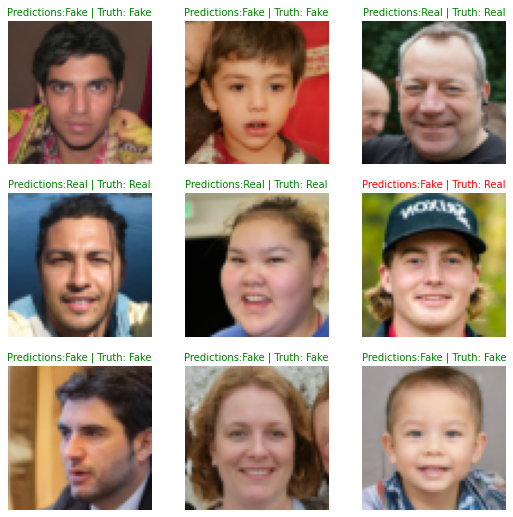

In [ ]:
plt.figure(figsize=(9,9))
rows=3
cols=3
torch.manual_seed(52)
for i,sample in enumerate(test_samples):
  plt.subplot(rows,cols,i+1)
  plt.imshow(sample.squeeze().permute(1,2,0),cmap="gray")
  pred_label= class_names[pred_classes[i]]
  truth_label= class_names[test_labels[i]]
  title_text= f"Predictions:{pred_label} | Truth: {truth_label}"
  if pred_label==truth_label:
    plt.title(title_text, fontsize=10, c="g")
  else:
    plt.title(title_text, fontsize=10, c='r')
  plt.axis(False)



**Training the MesoNetInception Model**

In [ ]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

NUM_EPOCHS = 15

model_Meso1= MesoInception4(input_features=3, output_features=2).to(device)
loss_fn= nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_Meso1.parameters(), lr=0.001, betas=(0.9, 0.999), eps=1e-08)

model_CNN_results= train(model=model_Meso1,
                         train_dataloader=train_dataloader,
                         test_dataloader= test_dataloader,
                         optimizer=optimizer,
                         loss_fn= loss_fn,
                         epochs=NUM_EPOCHS)